In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.auto import tqdm
from utils import *
from setups import uncertainties, methods_config, metrics_config, variable_config, methods_no_pred_estimate, uncertainties_config, metrics_set_up


exp = "ExpA"

c:\Users\Chris\Anaconda3\envs\logistic\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
simulation_set_up = pd.read_csv(os.path.join("data", exp, "simulation_set_up.csv"))

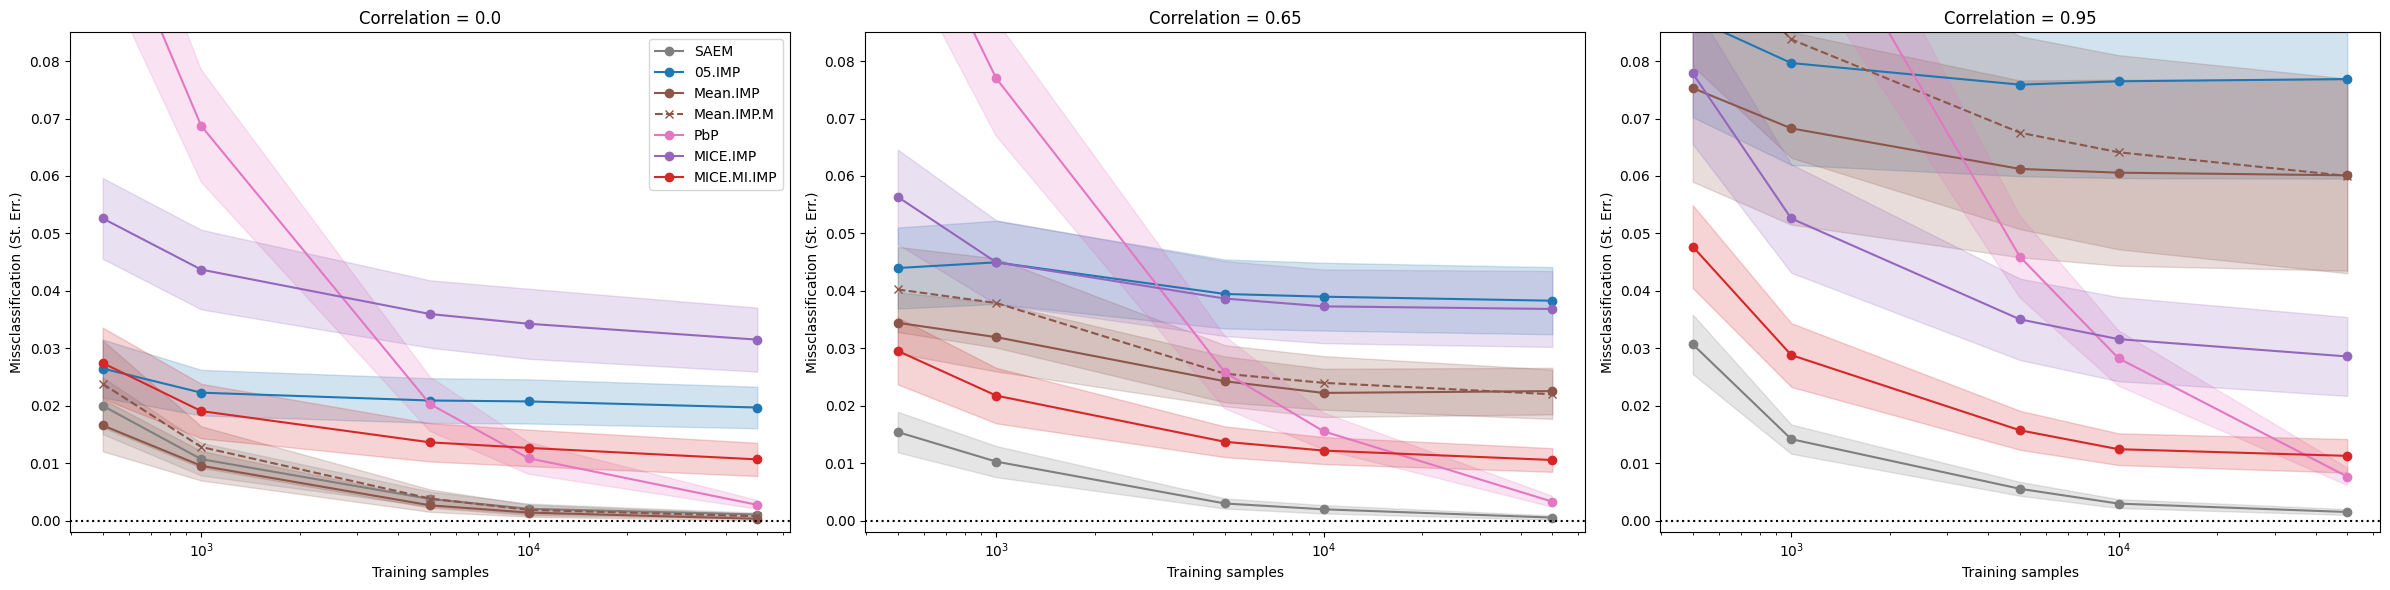

In [3]:




def plot_one_subplot_pred(
        ax,
        df,
        metric,
        uncertainty,
        pattern,
        diff_bayes,
):
    all_methods = df["method"].unique()
    all_training_samples = df["n_train"].unique()

    dict_all_scores = {}

    for method in all_methods:
        dict_all_scores[method] = {}
        for n_train in all_training_samples:
            dict_all_scores[method][n_train] = []
            
    for i, row_set_up in df.iterrows():
        method = row_set_up["method"]
        n_train = row_set_up["n_train"]

        if pattern is not None:
            M = np.load(os.path.join("data", exp, "test_data",f"{row_set_up['set_up']}.npz"))["M"]
            idx_pattern = get_index_pattern(pattern, M, remove_all_missing=True)

        pred = np.load(os.path.join("data", exp, "pred_data",f"{row_set_up['file_name']}.npz"))["y_probs_pred"].ravel()
        pred = pred[idx_pattern] if pattern is not None else pred

        true = np.load(os.path.join("data", exp, "test_data",f"{row_set_up['set_up']}.npz"))["y_probs"].ravel()
        true = true[idx_pattern] if pattern is not None else true

        score = metrics_set_up[metric](true, pred)

        if diff_bayes:
            bayes = np.load(os.path.join("data", exp, "bayes_data",f"{row_set_up['set_up']}.npz"))["y_probs_bayes"]
            bayes = bayes[idx_pattern] if pattern is not None else bayes

            score -= metrics_set_up[metric](true, bayes)

        dict_all_scores[method][n_train].append(score)

    dict_mean_scores = {}
    dict_uncertainty_scores = {}
    for method in all_methods:
        dict_mean_scores[method] = {}
        dict_uncertainty_scores[method] = {}
        for n_train in all_training_samples:
            dict_mean_scores[method][n_train] = np.mean(dict_all_scores[method][n_train])
            dict_uncertainty_scores[method][n_train] = uncertainties[uncertainty](dict_all_scores[method][n_train])
        
    for method in all_methods:
        
        x = dict_mean_scores[method].keys() #n_train
        y = [dict_mean_scores[method][n_train] for n_train in x]

        yerr = [dict_uncertainty_scores[method][n_train] for n_train in x]
        ax.plot(x, y, label=methods_config[method]["label"], color=methods_config[method]["color"], 
                linestyle=methods_config[method]["linestyle"], marker=methods_config[method]["marker"])
        ax.fill_between(x, np.array(y) - np.array(yerr), np.array(y) + np.array(yerr), alpha=0.2, 
                        color=methods_config[method]["color"])

    return ax


def plot_pred_scores_subplots(
        
        data,

        metric = "missclassification_error",
        variable = "corr",
        uncertainty = "se",
        pattern = None,
        diff_bayes = True,

        log_x = True,
        log_y = False,
        min_y = None,
        max_y = None,

        select_methods = None,
        remove_methods = None,
        save = None,

        size_height = 5,
        size_width = 5,

        ##

        **kwargs
):
    
    df = filter_data(data, **kwargs)

    methods = df["method"].unique()
    if select_methods is not None:
        methods = [m for m in methods if m in select_methods]
    if remove_methods is not None:
        methods = [m for m in methods if m not in remove_methods]
    methods = [m for m in methods if m not in methods_no_pred_estimate]
    df = df[df["method"].isin(methods)]

    variables = df[variable].unique()

    fig, axs = plt.subplots(1, len(variables), figsize=(size_width*len(variables), size_height))
    if len(variables) == 1:
        axs = [axs]

    for i, var in enumerate(variables):

        ax = axs[i]
        df_ = df[df[variable] == var]
        plot_one_subplot_pred(ax, df_, metric, uncertainty, pattern, diff_bayes)

        if variable != "d":
            ax.set_title(f"{variable_config[variable]['label']} = {var}")
        ax.set_xlabel("Training samples")
        ax.set_ylabel(f"{metrics_config[metric]['label']} ({uncertainties_config[uncertainty]['label']})")
        ax.set_ylim(min_y, max_y)
        if i == 0:
            ax.legend()

        if log_x:
            ax.set_xscale("log")
        if log_y:
            ax.set_yscale("log")
        if diff_bayes:
            ax.axhline(0, color="black", linestyle=":")
    

    plt.tight_layout()
    if save is not None:
        plt.savefig(save)

    plt.show()



remove_methods=["05.IMP.M", "ICE.IMP", "ICE.IMP.M", "ICEY.IMP.M", "ICEY.IMP", "MICE.Y.IMP", "MICE.Y.M.IMP", "MICE.M.IMP"]
select_methods=None 
# remove_methods = None
# select_methods= ["MICE.IMP", "MICE.M.IMP", "MICE.Y.IMP", "MICE.Y.M.IMP", "MICE.5.IMP"]

metric = "missclassification_error"

plot_pred_scores_subplots(

    simulation_set_up,
    metric = metric,
    variable="corr",
    diff_bayes=True,
    pattern = None,

    max_y = 0.085,
    min_y = -0.002,

    remove_methods=remove_methods,
    select_methods=select_methods,

    size_height = 6,
    size_width = 8,

    # save="data/ExpA/figures/classification_corr.pdf"

)


In [4]:
plot_pred_scores_subplots(

    simulation_set_up,
    metric = metric,
    variable="centricity",
    diff_bayes=True,
    pattern = None,

    max_y = 0.20,

    remove_methods=remove_methods,
    select_methods=select_methods,

    size_height = 6,
    size_width = 7,
)

KeyError: 'centricity'

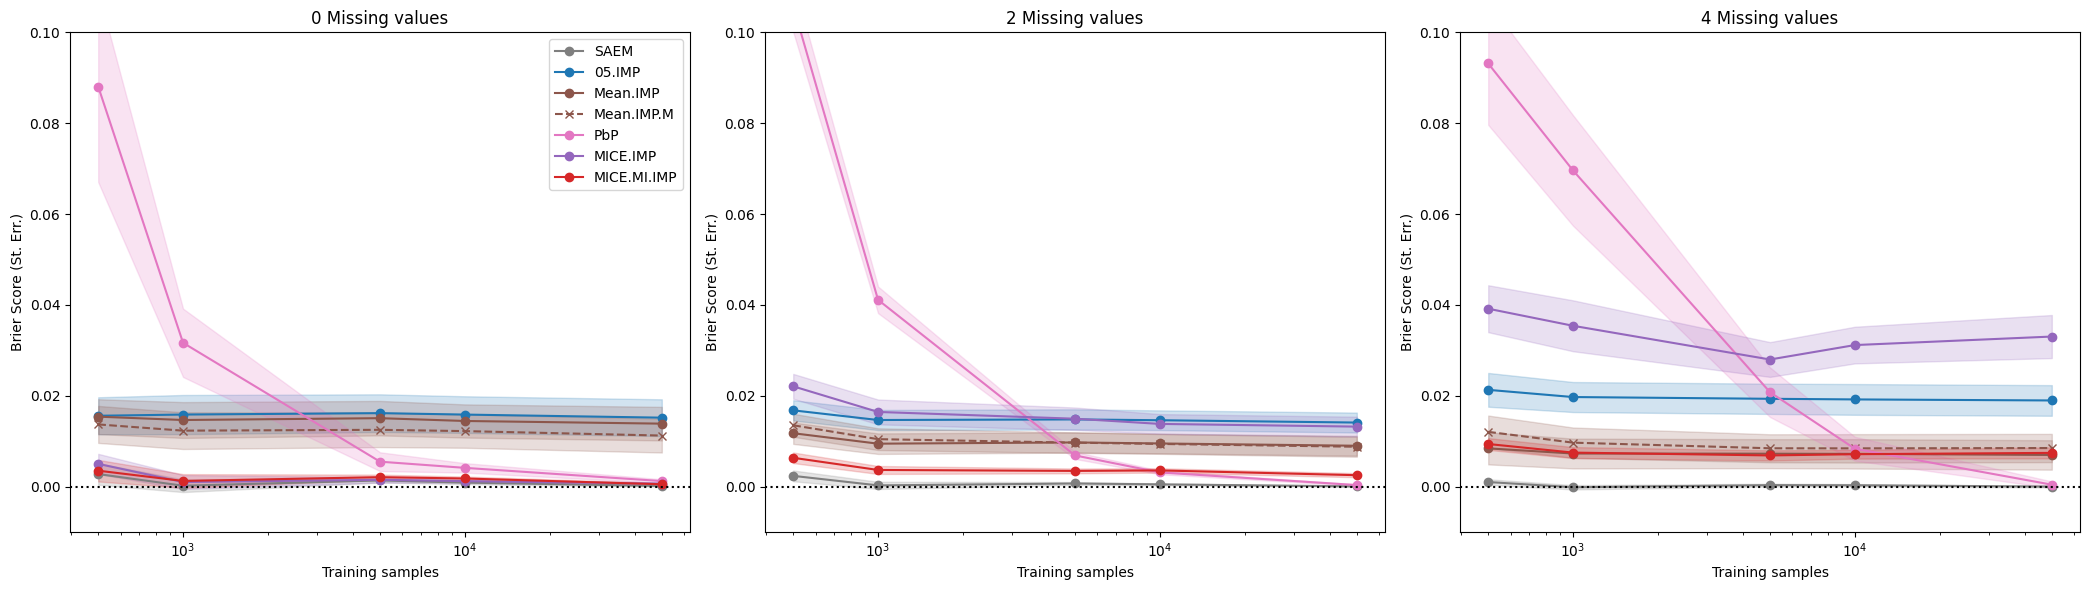

In [ ]:

def plot_pred_scores_patterns(
        
        data,

        metric = "missclassification_error",
        uncertainty = "se",
        patterns = None,
        diff_bayes = True,

        log_x = True,
        log_y = False,
        min_y = None,
        max_y = None,

        select_methods = None,
        remove_methods = None,
        save = None,

        size_height = 5,
        size_width = 5,

        ##

        **kwargs
):
    
    if patterns is None:
        patterns = [0, 2, 4]
    patterns = np.sort(patterns)
    patterns = [int(p) for p in patterns]

    df = filter_data(data, **kwargs)

    methods = df["method"].unique()
    if select_methods is not None:
        methods = [m for m in methods if m in select_methods]
    if remove_methods is not None:
        methods = [m for m in methods if m not in remove_methods]
    methods = [m for m in methods if m not in methods_no_pred_estimate]
    df = df[df["method"].isin(methods)]

    fig, axs = plt.subplots(1, len(patterns), figsize=(size_width*len(patterns), size_height))
    if len(patterns) == 1:
        axs = [axs]

    for i, pat in enumerate(patterns):

        ax = axs[i]
        plot_one_subplot_pred(ax, df, metric, uncertainty, pat, diff_bayes)

        ax.set_title(f"{pat} Missing values")
        ax.set_xlabel("Training samples")
        ax.set_ylabel(f"{metrics_config[metric]['label']} ({uncertainties_config[uncertainty]['label']})")
        ax.set_ylim(min_y, max_y)
        if i == 0:
            ax.legend()

        if log_x:
            ax.set_xscale("log")
        if log_y:
            ax.set_yscale("log")
        if diff_bayes:
            ax.axhline(0, color="black", linestyle=":")
    

    plt.tight_layout()
    if save is not None:
        plt.savefig(save)

    plt.show()


metric = "brier_score"
remove_methods=["05.IMP.M", "ICE.IMP", "ICE.IMP.M", "ICEY.IMP.M", "ICEY.IMP", "MICE.Y.IMP", "MICE.Y.M.IMP", "MICE.M.IMP"]
select_methods=None 

plot_pred_scores_patterns(
    
    simulation_set_up,
    metric = metric,
    diff_bayes=True,
    patterns=[0, 2, 4],

    max_y = 0.10,
    min_y = -0.01,

    remove_methods=remove_methods,
    select_methods=select_methods,

    size_height = 6,
    size_width = 7,

    # save = "data/ExpA/figures/brier_patterns.pdf"
    
)